## Initialitzation

In [1]:
import copy
import os
import random

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from google.colab import drive
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.optim import Adam



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/DeepLearning_2024/FINALPROJECTCNN/Models'
data_path_train = '/content/drive/My Drive/DeepLearning_2024/FINALPROJECTCNN/Data/Train'
data_path_test = '/content/drive/My Drive/DeepLearning_2024/FINALPROJECTCNN/Data/Test'

Mounted at /content/drive


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # 3 x 128 x 128
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 16 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 x 64 x 64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 32 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 x 32 x 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1), #128 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2), #128 x 8 x 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
#Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 40
img_size = 128

In [5]:
class CenterSquareCrop(object): #Crops the image mantaining the aspect ratio.
    def __call__(self, img):
        # Get dimensions
        width, height = img.size
        min_dim = min(width, height)
        left = (width - min_dim) // 2
        top = (height - min_dim) // 2
        right = (width + min_dim) // 2
        bottom = (height + min_dim) // 2
        img = img.crop((left, top, right, bottom))
        return img

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20, translate=(0.05, 0.05), scale=(0.85, 1.15), shear=0),
    transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.15, hue=0.15),
    CenterSquareCrop(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

    #transforms.Normalize((0.5,), (0.5,)),

In [6]:
train_dataset = ImageFolder(data_path_train, transform=transform)
test_dataset = ImageFolder(data_path_test, transform=transform)

# Create the DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

In [7]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

489
123


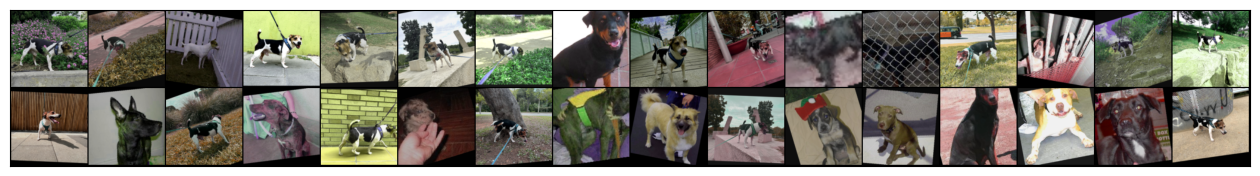

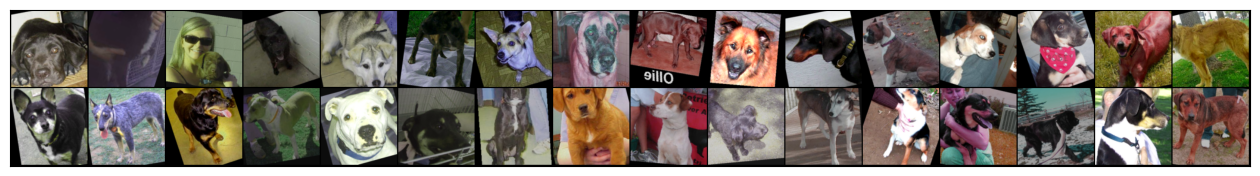

In [ ]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_loader)
show_batch(test_loader)

## Version control

In [9]:
################################################################################
################################################################################
version = 20
model_file_name = f"pincho_detector_{str(num_epochs)}_{str(version).zfill(3)}.pth"
print(f"Current working model name: \t{model_file_name}")
save_path = os.path.join(model_path, model_file_name)
################################################################################
################################################################################

Current working model name: 	pincho_detector_40_020.pth


## Train or load model

In [ ]:
model = CNN().to(device) #train from scratch

In [10]:
# load model:
print(f"Currenly using: {device}")
model = CNN().to(device)
model.load_state_dict(torch.load(save_path, map_location=device))


Currenly using: cuda:0


<All keys matched successfully>

In [11]:
# Set Loss function with criterion
#Set optimizer
optimizer = Adam(model.parameters(), lr=0.001)
total_step = len(train_loader)


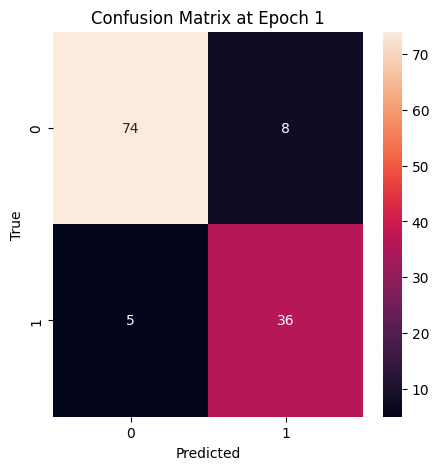

Epoch [1/10], Train Loss: 0.4925, Test Loss: 0.4395


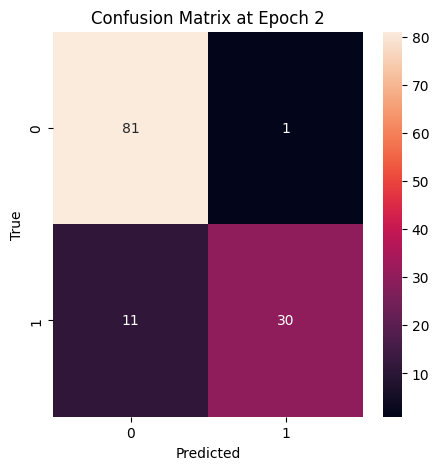

Epoch [2/10], Train Loss: 0.3421, Test Loss: 0.4688


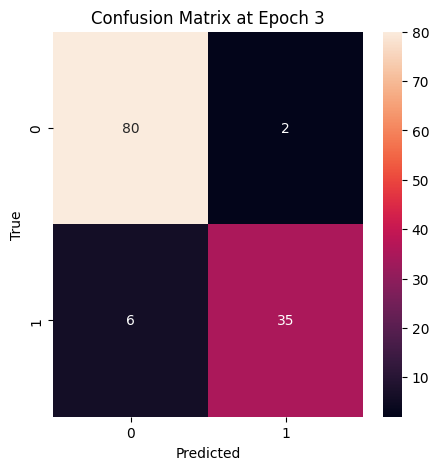

Epoch [3/10], Train Loss: 0.2346, Test Loss: 0.3622


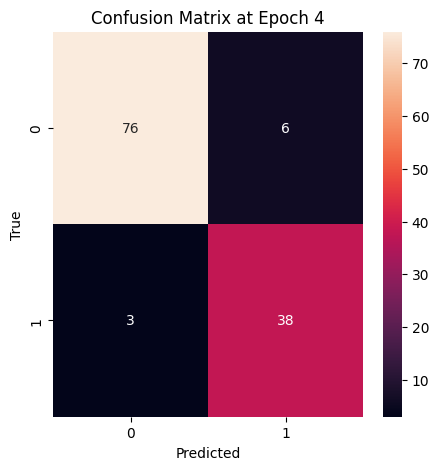

Epoch [4/10], Train Loss: 0.2102, Test Loss: 0.4079


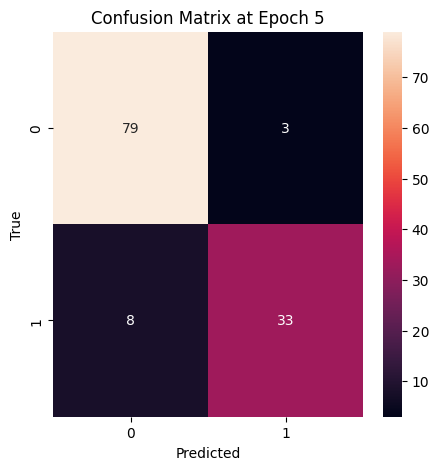

Epoch [5/10], Train Loss: 0.4000, Test Loss: 0.4093


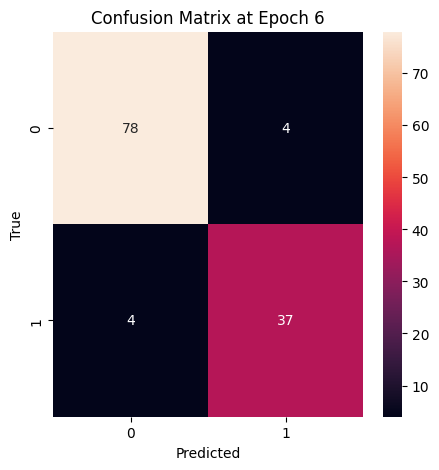

Epoch [6/10], Train Loss: 0.3595, Test Loss: 0.4309


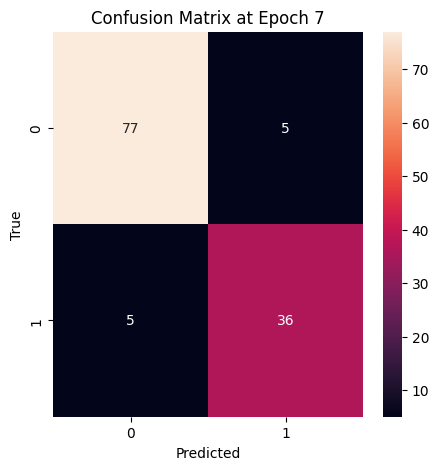

Epoch [7/10], Train Loss: 0.3026, Test Loss: 0.4512


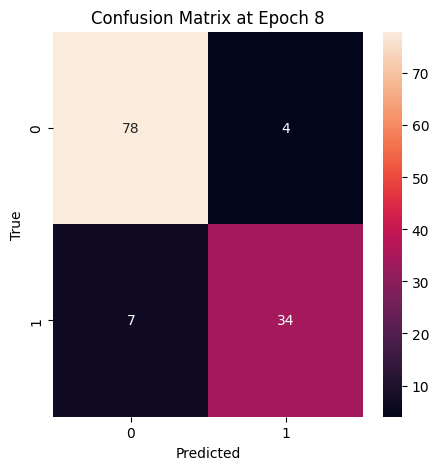

Epoch [8/10], Train Loss: 0.2951, Test Loss: 0.5068


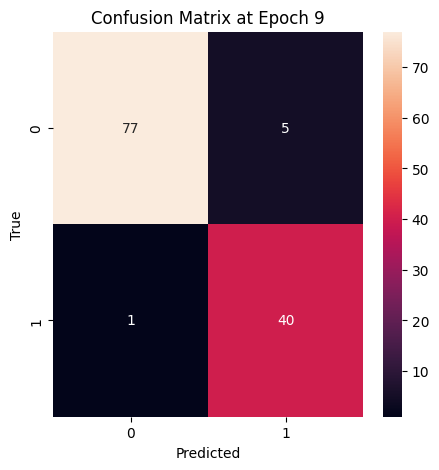

Epoch [9/10], Train Loss: 0.1913, Test Loss: 0.3534


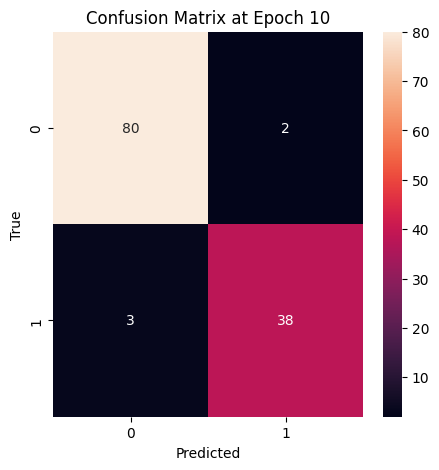

Epoch [10/10], Train Loss: 0.2561, Test Loss: 0.3305


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [ ]:
# Train model

# Define the class weights for BCELoss, weight for class 1 (your dog) is higher
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer confusion matrix visualization

# Define the class weights for BCELoss, weight for class 1 (your dog) is higher
weight = torch.tensor([2.0], device=device)  # Weight for the positive class (your dog)
criterion = nn.BCELoss(weight=weight)

train_losses = []
test_losses = []
early_stopping_patience = 15
min_test_loss = np.inf
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = outputs.round()  # Assuming binary classification
            all_preds.extend(predicted.view(-1).tolist())
            all_labels.extend(labels.view(-1).tolist())
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    # Print and compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix at Epoch {epoch+1}')
    plt.show()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Early stopping based on test loss
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(model.state_dict(), save_path)
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping initiated.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

## Test

In [13]:
from sklearn.metrics import confusion_matrix
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Threshold the outputs at 0.5 to determine the class
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1

        # Ensure labels are in the correct shape to compare with predicted
        labels = labels.float().unsqueeze(1)  # This makes sure labels are the same shape as predicted

        total += labels.size(0)  # Total number of labels

        # Compute number of correct predictions
        correct += (predicted == labels).sum().item()

        # Print statements to help debug
        print("Correct Predictions this Batch:", (predicted == labels).sum().item())

    # Calculate the accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the {len(train_loader.dataset)} train images: {accuracy:.2f} %")



KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Threshold the outputs at 0.5 to determine the class
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1

        # Ensure labels are in the correct shape to compare with predicted
        labels = labels.float().unsqueeze(1)  # This makes sure labels are the same shape as predicted

        total += labels.size(0)  # Total number of labels

        # Compute number of correct predictions
        correct += (predicted == labels).sum().item()

        # Print statements to help debug
        print("Correct Predictions this Batch:", (predicted == labels).sum().item())

    # Calculate the accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the {len(test_loader.dataset)} test images: {accuracy:.2f} %")


Correct Predictions this Batch: 30
Correct Predictions this Batch: 28
Correct Predictions this Batch: 29
Correct Predictions this Batch: 27
Accuracy of the network on the 123 test images: 92.68 %


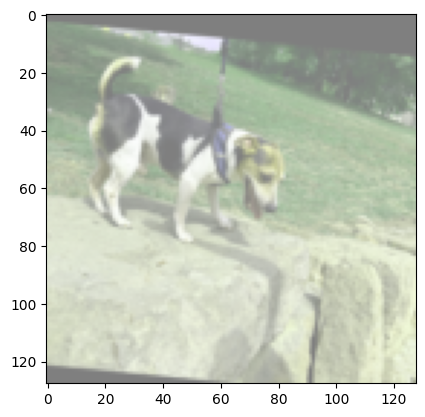

Label: 1.0, Output: 0.982585072517395


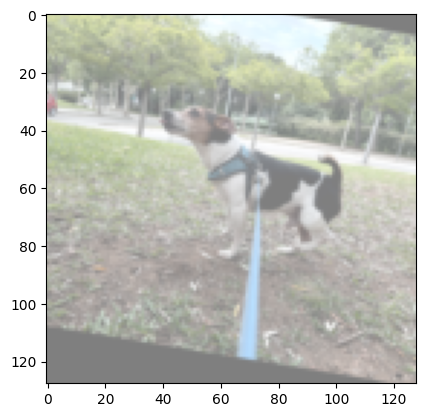

Label: 1.0, Output: 0.9741679430007935


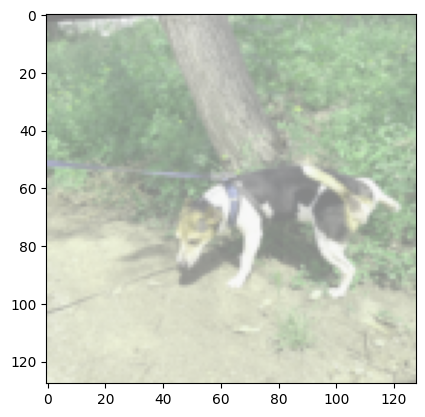

Label: 1.0, Output: 0.9640923738479614


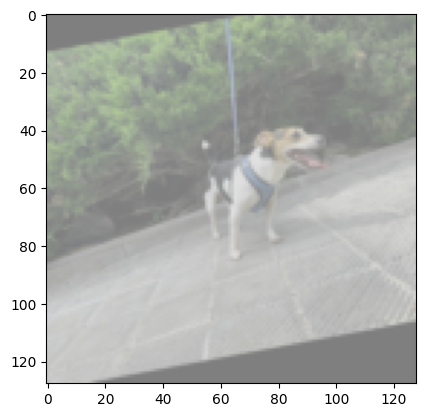

Label: 1.0, Output: 0.9603765606880188


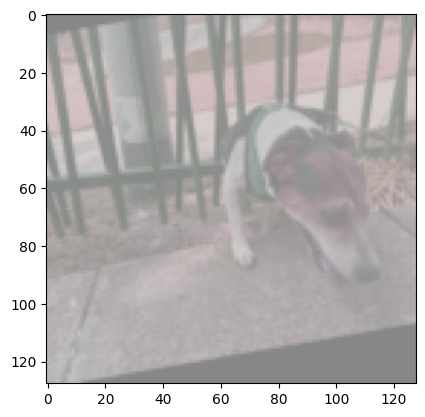

Label: 1.0, Output: 0.9457525014877319


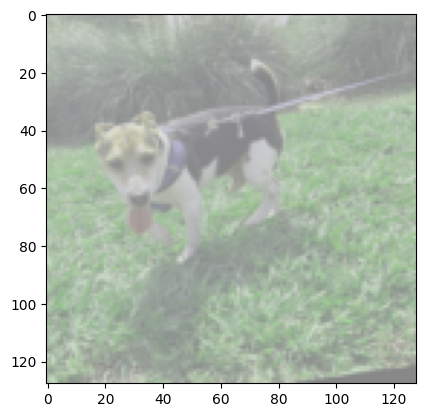

Label: 1.0, Output: 0.5494482517242432


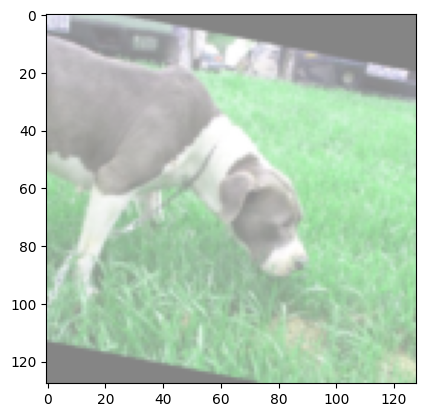

Label: 0.0, Output: 0.5048013925552368


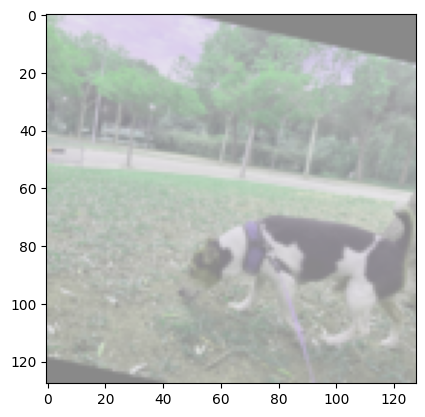

Label: 1.0, Output: 0.46520787477493286


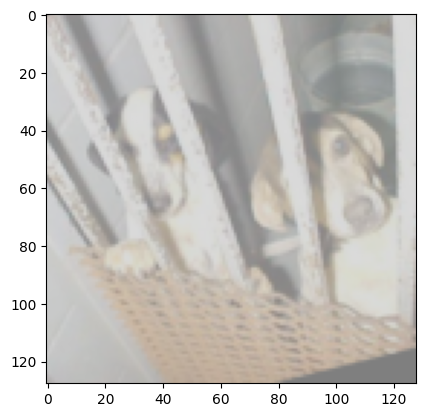

Label: 0.0, Output: 0.38736000657081604


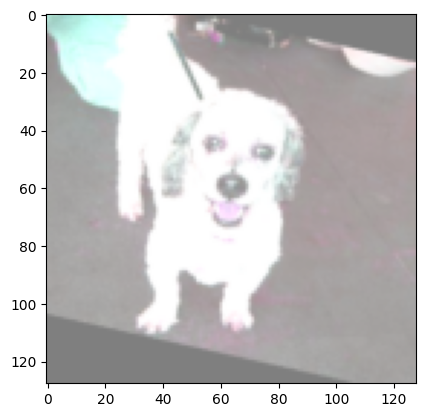

Label: 0.0, Output: 0.2722439765930176


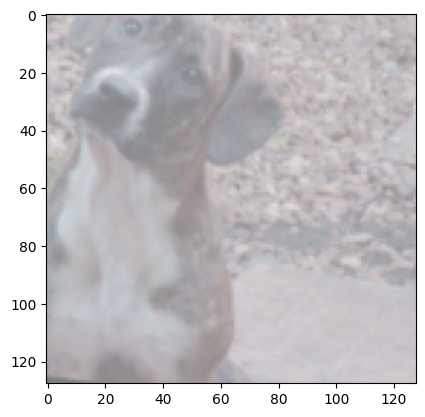

Label: 0.0, Output: 0.24398231506347656


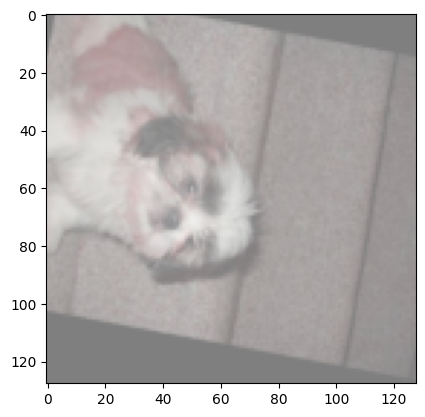

Label: 0.0, Output: 0.2419586330652237


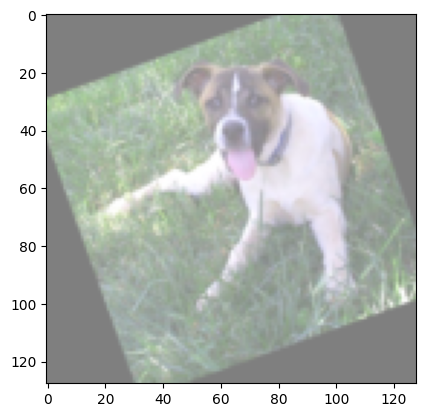

Label: 0.0, Output: 0.2188010960817337


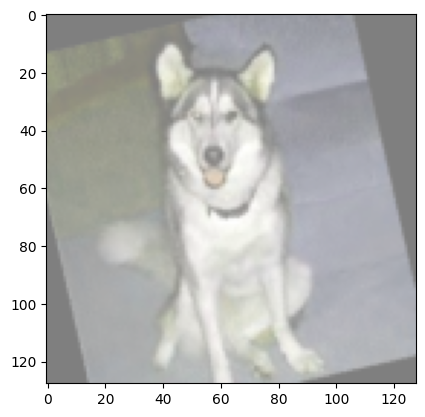

Label: 0.0, Output: 0.1838683933019638


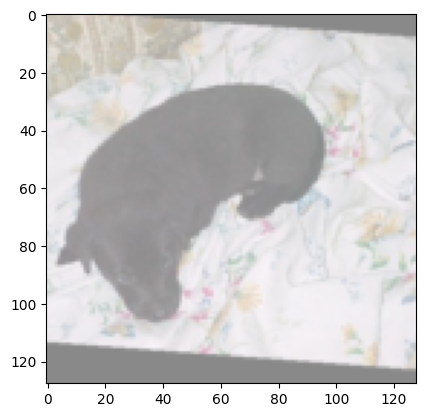

Label: 0.0, Output: 0.15012969076633453


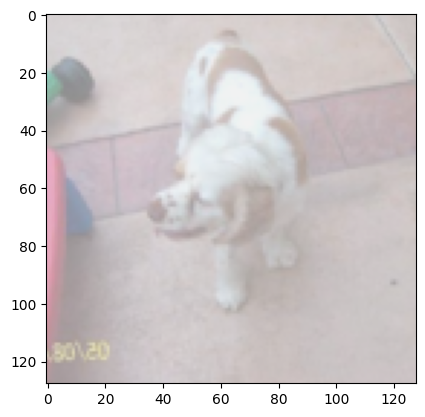

Label: 0.0, Output: 0.08818181604146957


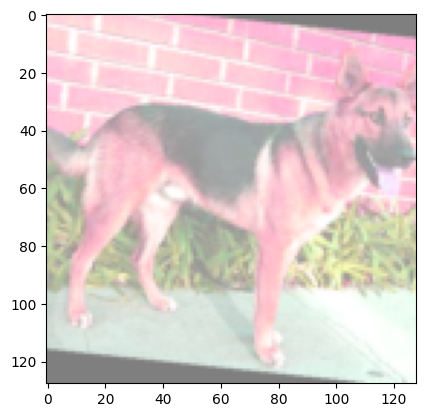

Label: 0.0, Output: 0.08079248666763306


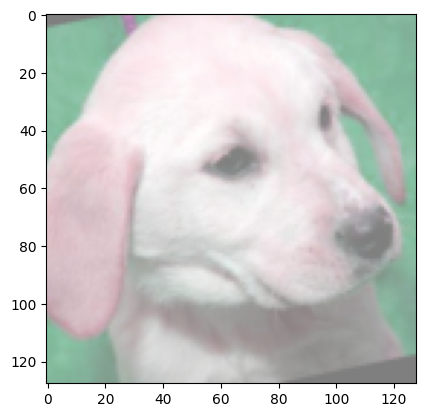

Label: 0.0, Output: 0.05055508762598038


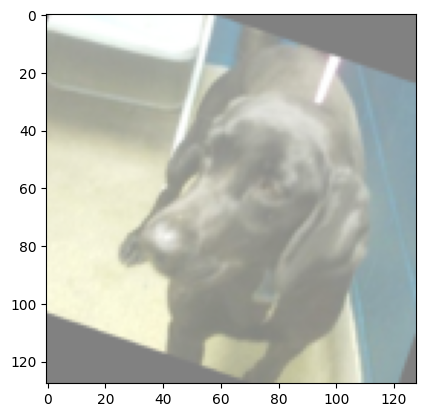

Label: 0.0, Output: 0.047457002103328705


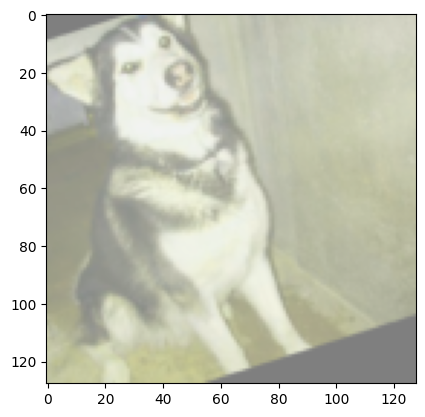

Label: 0.0, Output: 0.04141286760568619


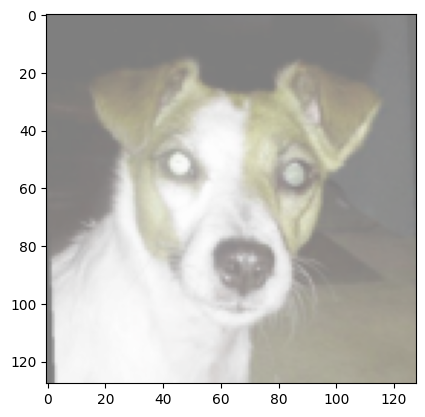

Label: 0.0, Output: 0.039639972150325775


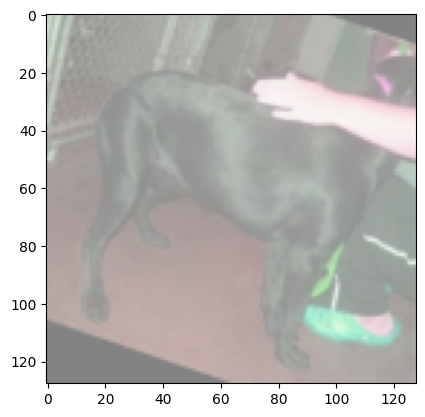

Label: 0.0, Output: 0.0319361537694931


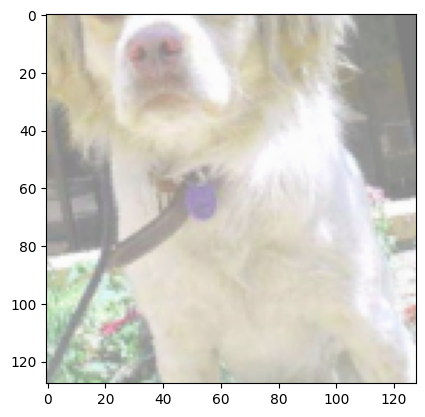

Label: 0.0, Output: 0.02693888358771801


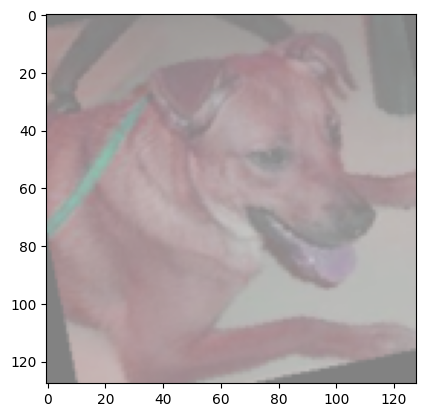

Label: 0.0, Output: 0.011170127429068089


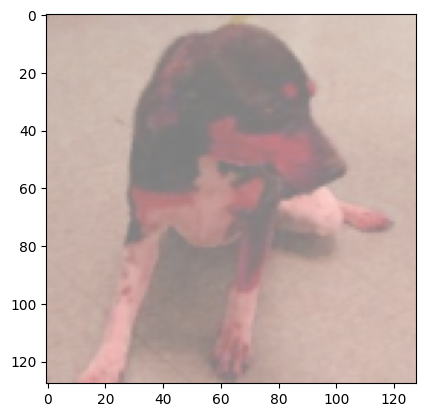

Label: 0.0, Output: 0.008382153697311878


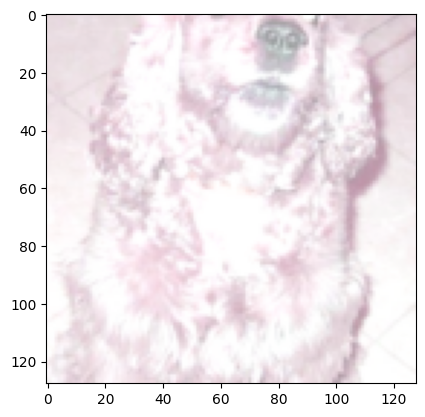

Label: 0.0, Output: 0.007705401163548231


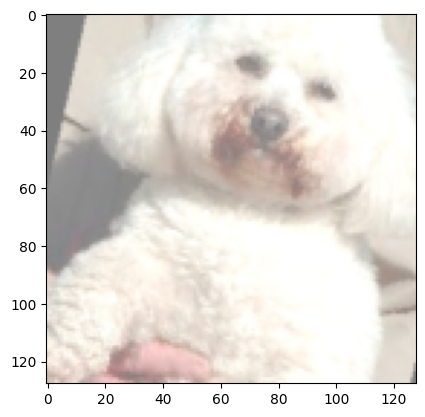

Label: 0.0, Output: 0.004003929439932108


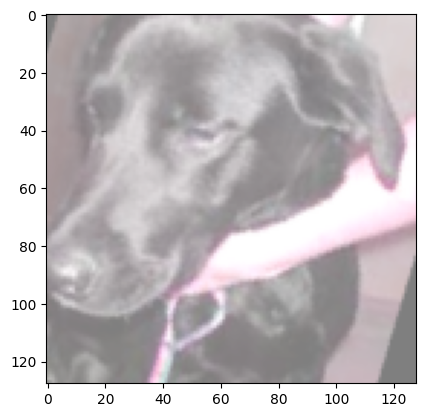

Label: 0.0, Output: 0.003859702730551362


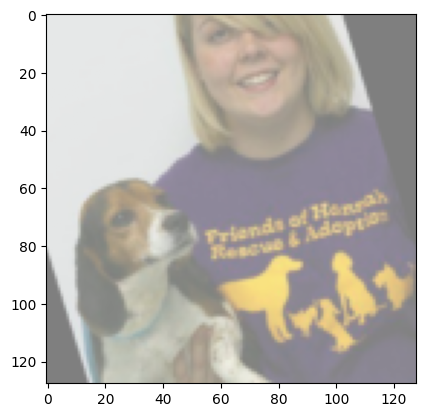

Label: 0.0, Output: 0.0007259242120198905


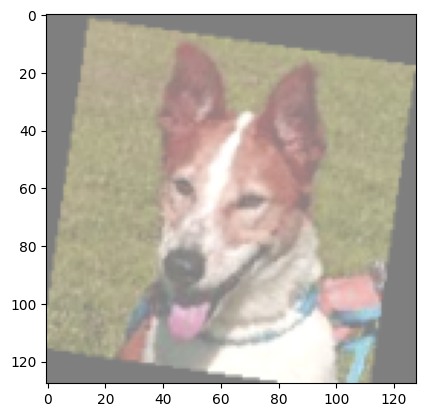

Label: 0.0, Output: 0.0005031587788835168


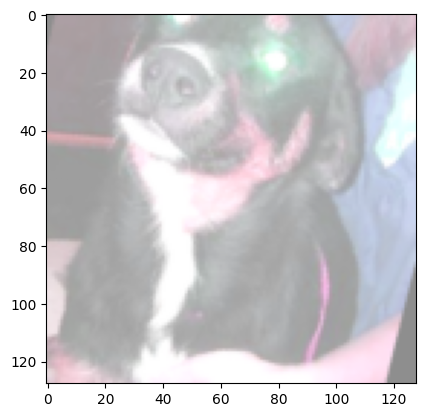

Label: 0.0, Output: 0.0003805982996709645


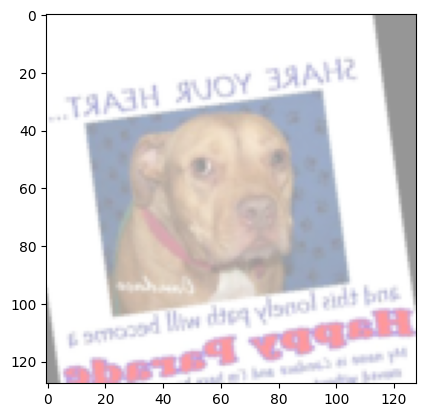

Label: 0.0, Output: 1.8720122170634568e-05


In [ ]:
# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()  # move to CPU if necessary
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize the top N predictions
N = 32  # Number of top predictions to visualize

for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device).float().unsqueeze(1)

    outputs = model(images)

    # Move tensors back to CPU for visualization
    images_cpu = images.cpu()
    labels_cpu = labels.cpu()
    outputs_cpu = outputs.cpu()

    # Get the indices of the top N predictions
    _, top_indices = torch.topk(outputs_cpu.squeeze(), N)

    # Show top N images and model outputs
    for j in top_indices:
        plt.figure()
        imshow(images_cpu[j])
        print(f'Label: {labels_cpu[j].item()}, Output: {outputs_cpu[j].item()}')

    break  # Visualize one batch only

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is RGB
    image = transform(image).unsqueeze(0).to(device)  # Apply transformation and add batch dimension
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = (output > 0.5).item() # Assuming 0.5 as the threshold
        print(output)
    return 'Your dog' if prediction else 'Not your dog'

# Path to the folder containing new images
folder_path = '/content/drive/My Drive/DeepLearning_2024/FINALPROJECTCNN/TestYourImage'
images = [f for f in os.listdir(folder_path) if f.endswith('.png',)]  # List only jpg files

# Predicting each image in the folder
results = {img: predict_image(os.path.join(folder_path, img)) for img in images}
print(results)


tensor([[0.9506]])
tensor([[0.7910]])
tensor([[0.3439]])
tensor([[0.4217]])
tensor([[0.3690]])
{'pnr.png': 'Your dog', '372497219919395.png': 'Your dog', 'pinchofondoarti.png': 'Not your dog', 'pinchofondoarti2.png': 'Not your dog', 'pinchofondoarti3.png': 'Not your dog'}
